In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Ticker            TSLA        TSLA        TSLA        TSLA       TSLA
Date                                                                 
2023-03-16  184.130005  185.809998  178.839996  180.369995  121136800
2023-03-17  180.130005  186.220001  177.330002  184.520004  133197100
2023-03-20  183.250000  186.440002  176.350006  178.080002  129684400
2023-03-21  197.580002  198.000000  188.039993  188.279999  153391400
2023-03-22  191.149994  200.660004  190.949997  199.300003  150376400


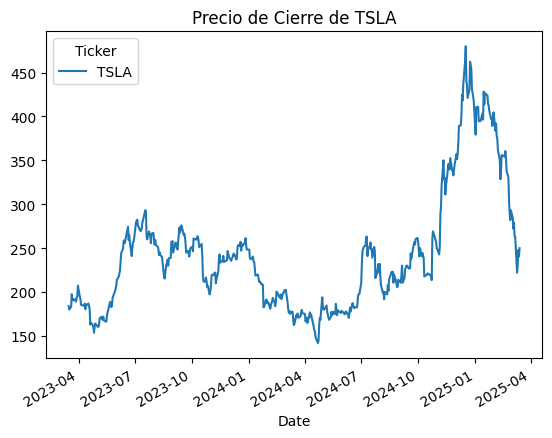

In [3]:
# 1. Especificar el ticker de la acción
ticker = 'TSLA'  # Aquí puedes poner el ticker que desees *Tesla*

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2023-03-16", end="2025-03-15")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

# 4. Opcional: Graficar los precios de cierre
import matplotlib.pyplot as plt

data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [13]:
# Eliminar MultiIndex y dejar solo los nombres de las columnas
data.columns = data.columns.droplevel(1)

# Mostrar las primeras filas
print(data.head())

Price            Close        High         Low        Open     Volume  \
Date                                                                    
2023-03-16  184.130005  185.809998  178.839996  180.369995  121136800   
2023-03-17  180.130005  186.220001  177.330002  184.520004  133197100   
2023-03-20  183.250000  186.440002  176.350006  178.080002  129684400   
2023-03-21  197.580002  198.000000  188.039993  188.279999  153391400   
2023-03-22  191.149994  200.660004  190.949997  199.300003  150376400   

Price       retornos  
Date                  
2023-03-16       NaN  
2023-03-17 -0.021963  
2023-03-20  0.017173  
2023-03-21  0.075292  
2023-03-22 -0.033085  


In [15]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

Price,Close,High,Low,Open,Volume,retornos
Date,,,,,,
2023-03-16,184.130005,185.809998,178.839996,180.369995,121136800,NaN
2023-03-17,180.130005,186.220001,177.330002,184.520004,133197100,-0.021963
2023-03-20,183.250000,186.440002,176.350006,178.080002,129684400,0.017173
2023-03-21,197.580002,198.000000,188.039993,188.279999,153391400,0.075292
2023-03-22,191.149994,200.660004,190.949997,199.300003,150376400,-0.033085


In [16]:
#Metodo 1 tasa de crecimiento esperada
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.0006114776823468952


In [7]:
#Metodo 2 tasa de crecimiento esperada
data['retornos'].mean()

np.float64(0.0006114776823468952)

In [8]:
#Metodo 1 Volatilidad
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.036688081217716294


In [9]:
#Metodo 2 Volatilidad
sigma = data['retornos'].std()
sigma

0.03668808121771628

In [17]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=data[col_name].iloc[-1] #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)


    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [18]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.

    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)

    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido

    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Mostrar la cuadrícula
    plt.grid(True)

    # Mostrar leyenda
    #plt.legend()

    # Mostrar el gráfico
    plt.show()

In [21]:
# Ahora simulamos 500 veces cual podria ser el comportamiento del activo el proximo año
Montecarlo_results = pd.DataFrame()

sim=500

for i in range(0,sim):

    print(i)

    Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Montecarlo_results['sim_'+str(i)]=pd.concat([data['Close'],pd.Series(MGB_acciones(mu, sigma, data, 'Close',252))])
<ipython-input-21-fd2ee8e195a8>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

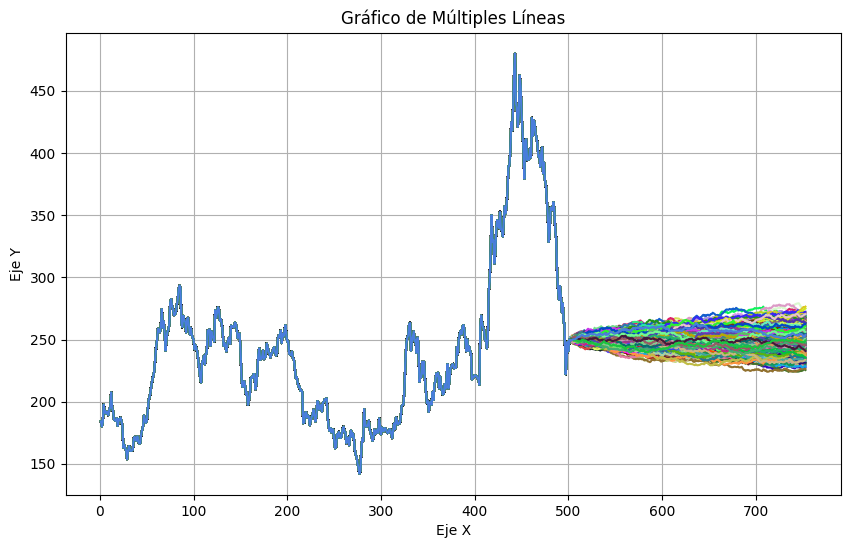

In [22]:
#Graficamos
lineas_multiples(Montecarlo_results, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [23]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
s0=data['Close'].iloc[-1]
print('El precio de compra es: ', s0)

El precio de compra es:  249.97999572753906


In [24]:
Montecarlo_results.tail()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
247,245.060170,253.889526,261.899954,242.462296,246.583346,249.983895,236.496401,232.380361,245.998721,259.168882,...,260.122181,248.649864,244.695258,242.668810,257.552391,247.358856,245.787520,243.026236,247.658777,254.434878
248,246.253485,253.848886,262.095811,242.738049,246.249521,249.898532,235.624623,232.187569,245.725537,259.527361,...,261.112647,247.726327,245.890202,243.424709,257.797072,247.347850,245.966486,242.609533,248.049479,253.039617
249,247.391496,254.418524,261.491733,243.487341,246.678018,250.976859,235.919633,230.702008,245.401174,259.153935,...,261.930366,246.931416,245.766321,243.869041,257.953450,247.818862,245.657092,242.207400,247.828266,252.366541
250,247.491175,254.333839,261.781118,242.882050,247.650876,251.251410,237.192394,230.613027,246.514465,259.360372,...,262.649860,247.031176,245.930813,245.039516,256.247175,248.058637,245.228103,241.620713,248.177786,252.330075
251,246.884104,253.494080,262.255212,242.430051,246.882306,251.060002,236.691119,231.477408,246.638462,258.965833,...,262.368270,246.813290,246.606253,246.373831,256.114122,247.614900,245.738293,240.755726,249.143957,253.832071


In [25]:
precios_cierre = Montecarlo_results.iloc[-1,:] #Seleccionamos los precios finales a un año de inversion
precios_cierre

,251
sim_0,246.884104
sim_1,253.494080
sim_2,262.255212
sim_3,242.430051
sim_4,246.882306
...,...
sim_495,247.614900
sim_496,245.738293
sim_497,240.755726
sim_498,249.143957


In [26]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre<(s0*0.95)])

p=exito/total

print(p*100,'%')

8.799999999999999 %


In [48]:
# Probabilidades de pérdida y ganancia del 10%
s0 = data['Close'].iloc[-1]  # Último precio
precios_finales = Montecarlo_results.iloc[-1, :].values

# Definir umbrales de pérdida y ganancia
umbral_perdida = 0.9 * s0
umbral_ganancia = 1.1 * s0

prob_perdida = np.mean(precios_finales < umbral_perdida)
prob_ganancia = np.mean(precios_finales > umbral_ganancia)

# Mostrar resultados
print(f"Precio de compra: {s0}")
print(f"Probabilidad de perder 10%: {prob_perdida * 100:.2f}%")
print(f"Probabilidad de ganar 10%: {prob_ganancia * 100:.2f}%")

Precio de compra: 249.97999572753906
Probabilidad de perder 10%: 0.00%
Probabilidad de ganar 10%: 0.40%


##EJERCICIO PRÁCTICO

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Datos
lambda_poisson = 1
media_gamma = 2_000_000
dv_gamma = 1_000_000

In [17]:
# Convertir media y dv std a parámetros de la distb Gamma
shape_gamma = (media_gamma / dv_gamma) ** 2  # k (forma)
scale_gamma = (dv_gamma ** 2) / media_gamma  # theta (escala)

# Simulación de Montecarlo
n_simulaciones = 500
costos_totales = []

for _ in range(n_simulaciones):
    n_siniestros = np.random.poisson(lambda_poisson)
    costos = np.random.gamma(shape_gamma, scale_gamma, size=n_siniestros)
    costos_totales.append(np.sum(costos))

In [18]:
# Estadísticas de la simulación
costos_totales = np.array(costos_totales)
media_simulada = np.mean(costos_totales)



In [19]:
# Resultados clave
print(f"Costo promedio estimado: ${media_simulada:,.0f}")


Costo promedio estimado: $2,192,223


###EJERCICIOS CONVERSIÓN DE TASAS

In [68]:
def tasanominal_EA(tasa_nominal, periodos):
    return (1 + tasa_nominal / periodos) ** periodos - 1
resultado = tasanominal_EA(0.34, 12)
print(resultado)


0.39832126999144113


In [69]:
def tasa_nominaltri_EA(tasa_nominal, periodos):
    return ((1 + tasa_nominal / periodos) ** periodos) - 1
resultado = tasa_nominaltri_EA(0.36, 4)
print(resultado)

0.4115816100000005


In [75]:
def tasaEA__nominalmens (tasa_efectiva_anual, periodos):
    return (((1 + tasa_efectiva_anual) ** (1 / periodos)) - 1)* periodos
resultado = tasaEA__nominalmens(0.4116, 12)
print(resultado)

0.3497230063839467


In [71]:
def tasaESemes_EA(tasa_efectiva_semestral,periodos):
    return ((1 + tasa_efectiva_semestral) ** 2) - 1
resultado = tasaESemes_EA(0.12, 2)
print(resultado)

0.2544000000000002


In [72]:
def tasaEA_semestral(tasa_efectiva_anual,periodos):
    return (1 + tasa_efectiva_anual) ** (1 / 2) - 1
resultado = tasaEA_semestral(0.12, 2)
print(resultado)

0.05830052442583633
